In [1]:
from os import listdir
from os.path import isfile, join
import glob
import utils as u
from tqdm import tqdm
import cv2
import numpy as np
import scipy.ndimage as spimg
import imageio
import h5py
import lmdb

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from IPython.display import Image
from IPython.core.display import HTML 
import ipywidgets as widgets
from ipywidgets import interact

/work/kabelitz/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
semantic_labels = u.load_labels('../data/S2D3D/assets/semantic_labels.json')

label_set = set()
for entry in semantic_labels:
    label_set.add(u.parse_label(entry)['instance_class'])
label_list = sorted(list(label_set))
label_to_idx = {}
idx_to_label = {}
for idx, label in enumerate(label_list):
    label_to_idx[label] = idx
    idx_to_label[idx] = label
print(label_to_idx)
print(idx_to_label)

{'<UNK>': 0, 'beam': 1, 'board': 2, 'bookcase': 3, 'ceiling': 4, 'chair': 5, 'clutter': 6, 'column': 7, 'door': 8, 'floor': 9, 'sofa': 10, 'table': 11, 'wall': 12, 'window': 13}
{0: '<UNK>', 1: 'beam', 2: 'board', 3: 'bookcase', 4: 'ceiling', 5: 'chair', 6: 'clutter', 7: 'column', 8: 'door', 9: 'floor', 10: 'sofa', 11: 'table', 12: 'wall', 13: 'window'}


In [3]:
path_area_1  = '/work/kabelitz/data/S2D3D/area_1/'
path_area_2  = '/work/kabelitz/data/S2D3D/area_2/'
path_area_3  = '/work/kabelitz/data/S2D3D/area_3/'
path_area_4  = '/work/kabelitz/data/S2D3D/area_4/'
path_area_5a = '/work/kabelitz/data/S2D3D/area_5a/'
path_area_5b = '/work/kabelitz/data/S2D3D/area_5b/'
path_area_6  = '/work/kabelitz/data/S2D3D/area_6/'

paths_to_process = [path_area_1, path_area_2, path_area_3, path_area_4, path_area_5a, path_area_5b, path_area_6]

In [4]:
label_threshold = 0.75
void_label = 0

do_rgb = False
do_depth = False
do_label = False

one_hot_labels = np.eye(14,14)

for path in paths_to_process:
    names = u.load_names(path+'data/semantic/')
    for idx, name in enumerate(tqdm(names)):
        
        if do_rgb:
            img_rgb = cv2.imread(path + 'data/rgb/' + name + 'rgb.png')
            img_rgb = cv2.resize(img_rgb, (360, 360), interpolation=cv2.INTER_AREA)
            cv2.imwrite(path+'data/preprocessed/rgb/'+name+'rgb.png', img_rgb)
        
        if do_depth:
            img_depth = cv2.imread(path + 'data/depth/' + name + 'depth.png', cv2.IMREAD_ANYDEPTH)
            img_depth = cv2.resize(img_depth, (360, 360), interpolation=cv2.INTER_AREA)
            np.save(path+'data/preprocessed/depth/'+name+'depth.png', img_depth)
            # cv2.imwrite(path+'data/preprocessed/depth/'+name+'depth.png', img_depth)
        
        if do_label:
            img_label = cv2.cvtColor(cv2.imread(path + 'data/semantic/' + name + 'semantic.png'), cv2.COLOR_BGR2RGB)
            img_label = img_label.reshape(-1, 3)
            img_label[np.where((img_label==[13,13,13]).all(axis=1))] = [0,0,0]

            img_index_to_idx = {}
            unique_rgb = np.unique(img_label,axis=0)
            unique_indices = [u.get_index(rgb) for rgb in unique_rgb]
            label_for_unique_indices = [label_to_idx[u.parse_label(semantic_labels[index])['instance_class']] for index in unique_indices]

            img_one_hot = np.zeros((1080**2, 14))
            for idx, label in enumerate(label_for_unique_indices):
                img_one_hot[np.where((img_label==unique_rgb[idx]).all(axis=1))] = one_hot_labels[label]

            img_class_prob = cv2.resize(img_one_hot.reshape((1080, 1080, 14)), (360, 360), interpolation=cv2.INTER_AREA)
            max_idx = np.argmax(img_class_prob, 2)
            max_val = np.max(img_class_prob, 2)
            #print(np.unique(max_val))
            unique, counts = np.unique(max_idx, return_counts=True)
            #print(dict(zip(unique, counts)))
            max_idx[max_val < label_threshold] = void_label
            unique, counts = np.unique(max_idx, return_counts=True)
            #print(dict(zip(unique, counts)))
            cv2.imwrite(path+'data/preprocessed/label_area_interpolated/'+name+'label_area_interpolated.png', max_idx)    


100%|██████████| 9890/9890 [00:00<00:00, 2682293.34it/s]


  0%|          | 0/11332 [00:00<?, ?it/s]

k: (3, 3)
[[999.03460693   0.         540.        ]
 [  0.         999.03460693 540.        ]
 [  0.           0.           1.        ]]
rt: (3, 4)
[[ 9.90371525e-01 -1.38434842e-01  1.97877525e-04 -2.39432192e+00]
 [-3.18475254e-02 -2.29229778e-01 -9.72851217e-01  1.67080963e+00]
 [ 1.34721860e-01  9.63477790e-01 -2.31431454e-01 -6.79012239e-01]]


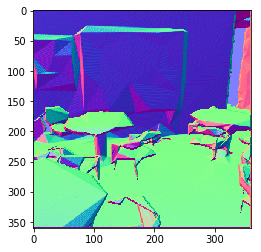

In [9]:
# make normal images from depth

paths_to_process = [path_area_5b]
for path in paths_to_process:
    names = u.load_names(path+'data/semantic/')
    for idx, name in enumerate(tqdm(names)):
        #if idx < 1000:
        #    continue
        #else:
        #    c += 1
        #print(name)
        
        camera_json = u.load_labels(path + 'data/pose/' + name + 'pose.json')
        camera_k_matrix = camera_json['camera_k_matrix']
        camera_rt_matrix = np.array(camera_json['camera_rt_matrix'])
        
        k = np.array(camera_k_matrix)
        rt = np.array(camera_rt_matrix)
        print('k:', k.shape)
        print(k)
        print('rt:', rt.shape)
        print(rt)

        img_rgb = cv2.cvtColor(cv2.imread(path + 'data/preprocessed/rgb/' + name + 'rgb.png'), cv2.COLOR_BGR2RGB)
        img_depth = cv2.imread(path + 'data/depth/' + name + 'depth.png', cv2.IMREAD_ANYDEPTH)
        img_depth[np.where((img_depth==(2**16)-1))] = -512.
        img_depth = cv2.resize(img_depth, (360, 360), interpolation=cv2.INTER_AREA)
        
        img_normal = np.zeros((360, 360, 3))
        img_normal[:,:,0] = (np.convolve(img_depth.reshape(-1), [0.5, 0, -0.5], 'same').reshape((360, 360))) * -1.0
        img_normal[:,:,1] = (np.transpose(np.convolve(np.transpose(img_depth).reshape(-1), [0.5, 0, -0.5], 'same').reshape((360,360)))) * -1.0
        img_normal[:,:,2] = np.ones((360,360))
        
        norms = np.linalg.norm(img_normal, axis=2).reshape((360,360,1))
        norms = np.repeat(norms, 3, axis=2)
        img_normal = np.divide(img_normal, norms)
        img_normal = (img_normal + 1.0) /2.0  # do this only if you want to plot normal images
        plt.imshow(img_normal)
        break
        
        img_normal_blur = spimg.filters.median_filter(img_normal, (5,5,1))
        
        gravity = np.array([0, 0, 1, 0])
        gravity = np.matmul(np.concatenate((camera_rt_matrix, [[0, 0, 0, 1]])), gravity)[:-1]
        img_angle = np.einsum('ijk,k->ij', img_normal_blur, gravity)
        img_angle = np.arccos(img_angle)
        
        img_y = np.repeat(np.arange(0,360,1).reshape((360, 1)), 360, axis=1)
        img_x = np.transpose(img_y)
        img_y = img_y - (camera_k_matrix[1][2] / 3)
        img_x = img_x - (camera_k_matrix[0][2] / 3)
        img_y = np.multiply(img_y, img_depth/512.) / (camera_k_matrix[1][1] / 3)
        img_x = np.multiply(img_x, img_depth/512.) / (camera_k_matrix[0][0] / 3)
        img_xyz = np.concatenate((img_x.reshape((360,360,1)), img_y.reshape((360,360,1)), img_depth.reshape((360,360,1)) / 512., np.ones((360,360,1))), axis=2)
        
        img_horizontal_displacement = img_xyz[:,:,2]
        
        rt_inv = np.linalg.inv(np.concatenate((camera_rt_matrix, [[0, 0, 0, 1]])))
        global_xyz = np.matmul(img_xyz, np.transpose(rt_inv))
        img_height = global_xyz[:,:,2]
        
        img_hha = np.concatenate((img_horizontal_displacement.reshape((360,360,1)), img_height.reshape((360,360,1)), img_angle.reshape((360,360,1))), axis=2).astype(np.float32)
        #np.save(path+'data/preprocessed/hha/'+name+'hha.npy', np.nan_to_num(img_hha))
        
        img_hha = img_hha.astype(np.float16)
        img_xy = img_xyz[:,:,:2].astype(np.float16)
        
        #np.save(path+'data/preprocessed/hha/'+name+'hha16.npy', np.nan_to_num(img_hha))
        #np.save(path+'data/preprocessed/xy/'+name+'xy16.npy', np.nan_to_num(img_xy))
        #cv2.imwrite(path+'data/preprocessed/x/'+name+'x.png', img_x)
        
        #f, axarr = plt.subplots(2, 2, figsize=(20, 17))
        #im1 = axarr[0,0].imshow(img_rgb)
        #im2 = axarr[0,1].imshow(img_hha[:,:,0])
        #im3 = axarr[1,0].imshow(img_hha[:,:,1])
        #im4 = axarr[1,1].imshow(img_hha[:,:,2])
        #plt.colorbar(im1, ax=axarr[0,0])
        #plt.colorbar(im2, ax=axarr[0,1])
        #plt.colorbar(im3, ax=axarr[1,0])
        #plt.colorbar(im4, ax=axarr[1,1])
        #plt.show()
        #break
    #break

In [ ]:
# make flip images

horizontal_disp_min = np.inf
horizontal_disp_max = -np.inf
height_min = np.inf
height_max = -np.inf
angle_min = 0.0
angle_max = 3.2

for path in paths_to_process:
    names = u.load_names(path+'data/semantic/')
    for idx, name in enumerate(tqdm(names)):
        #img_rgb = cv2.imread(path + 'data/preprocessed/rgb/' + name + 'rgb.png')
        #cv2.imwrite(path+'data/preprocessed/rgb/flip/'+name+'rgb.png', np.fliplr(img_rgb))
        img_label_area_interpolated = cv2.imread(path + 'data/preprocessed/label_area_interpolated/' + name + 'label_area_interpolated.png', cv2.IMREAD_ANYDEPTH)
        #cv2.imwrite(path+'data/preprocessed/label_area_interpolated/'+name+'label_area_interpolated.png', img_label_area_interpolated)
        #cv2.imwrite(path+'data/preprocessed/label_area_interpolated/flip/'+name+'label_area_interpolated.png', np.fliplr(img_label_area_interpolated))
        img_depth = cv2.imread(path + 'data/preprocessed/depth/' + name + 'depth.png', cv2.IMREAD_ANYDEPTH)
        #cv2.imwrite(path+'data/preprocessed/depth/'+name+'depth.png', img_depth)
        #cv2.imwrite(path+'data/preprocessed/depth/flip/'+name+'depth.png', np.fliplr(img_depth))
        
        img_hha = np.load(path + 'data/preprocessed/hha/' + name + 'hha.npy')
        #imageio.imwrite(path+'data/preprocessed/hha/'+name+'hha.tiff', img_hha)
        #imageio.imwrite(path+'data/preprocessed/hha/flip/'+name+'hha.tiff', np.fliplr(img_hha))
        
        # just stats collection for next cell
        #
        #ho_min = np.min(img_hha[:,:,0])
        #ho_max = np.max(img_hha[:,:,0])
        #if ho_min < horizontal_disp_min:
        #    horizontal_disp_min =  ho_min
        #if ho_max > horizontal_disp_max:
        #    horizontal_disp_max = ho_max
        #he_min = np.min(img_hha[:,:,1])
        #he_max = np.max(img_hha[:,:,1])
        #if he_min < height_min:
        #    height_min =  he_min
        #if he_max > height_max:
        #    height_max = he_max
            
            

In [ ]:
# discretize hha to uint8 range to save as .png for loading with opencv

horizontal_disp_min = 0.0
horizontal_disp_max = 51.603515625
height_min = -5.31698647452
height_max = 9.59365978533
angle_min = 0.0
angle_max = 3.2

for path in paths_to_process:
    names = u.load_names(path+'data/semantic/')
    for idx, name in enumerate(tqdm(names)):
        img_hha = np.load(path + 'data/preprocessed/hha/' + name + 'hha.npy')
        img_hha[:,:,0] = (img_hha[:,:,0] - horizontal_disp_min) / (horizontal_disp_max - horizontal_disp_min)
        img_hha[:,:,1] = (img_hha[:,:,1] - height_min) / (height_max - height_min)
        img_hha[:,:,2] = (img_hha[:,:,2] - angle_min) / (angle_max - angle_min)
        img_hha *= 2**8
        img_hha = img_hha.astype(np.uint8)
        #cv2.imwrite(path+'data/preprocessed/hha/'+name+'hha.png', img_hha)
        #cv2.imwrite(path+'data/preprocessed/hha/flip/'+name+'hha.png', np.fliplr(img_hha))

In [ ]:
print(height_max)
print(height_min)
print(horizontal_disp_max)
print(horizontal_disp_min)

#9.59365978533
#-5.31698647452
#51.603515625
#0.0

In [ ]:
img_rgb = cv2.cvtColor(cv2.imread('../data/S2D3D/area_1/data/preprocessed/rgb/camera_cfe68c10e7bf43d9b66ab2356eccec62_office_14_frame_11_domain_rgb.png'), cv2.COLOR_BGR2RGB)
a = plt.imshow(img_rgb)
plt.colorbar(a)

In [ ]:
img_label = cv2.imread('../data/S2D3D/area_1/data/preprocessed/label/camera_b786421e44c048b2af358011987c72ea_hallway_7_frame_40_domain_label.png', cv2.IMREAD_ANYDEPTH)
b = plt.imshow(img_label)
plt.colorbar(b)

In [ ]:
img_depth = cv2.imread('../data/S2D3D/area_1/data/preprocessed/depth/camera_b786421e44c048b2af358011987c72ea_hallway_7_frame_40_domain_depth.png', cv2.IMREAD_ANYDEPTH)
d = plt.imshow(img_depth)
plt.colorbar(d)

In [ ]:
img_semantic_pretty = mpimg.imread('../data/S2D3D/area_1/data/semantic_pretty/camera_f6c6ce3c012c49e6a28b2eb07f740753_hallway_7_frame_14_domain_semantic_pretty.png')
c = plt.imshow(img_semantic_pretty)
plt.colorbar(c)

In [6]:
data_path = '/fastwork/kabelitz/data/S2D3D/area_1/data/preprocessed/'
rgb_path = data_path + 'rgb/'
depth_path = data_path + 'depth/'
label_path = data_path + 'label_area_interpolated/'
hha_path = data_path + 'hha/'
semantic_pretty_path = '../data/S2D3D/area_1/data/semantic_pretty/'

rgb_file_names = [f for f in listdir(rgb_path) if isfile(join(rgb_path, f))]

def show_rgb_hha_label(i, with_colorbar=True):
    f, axarr = plt.subplots(3, 2, figsize=(20, 30))
    img_rgb = cv2.cvtColor(cv2.imread(rgb_path + rgb_file_names[i]), cv2.COLOR_BGR2RGB)
    im1 = axarr[0,0].imshow(img_rgb)
    #img_hha = cv2.imread(hha_path + rgb_file_names[i][:-7] + 'hha.png')
    img_hha = np.load(hha_path + rgb_file_names[i][:-7] + 'hha16.npy').astype(np.float32)
    
    print(img_hha.dtype)
    img_hha[:,:,0][np.where(np.logical_or(img_hha[:,:,0] > 15., img_hha[:,:,0] < -0.5))] = -2.
    img_hha[:,:,1][np.where(np.logical_or(img_hha[:,:,1] > 5., img_hha[:,:,1] < -0.5))] = -2.
    
    im2 = axarr[0,1].imshow(img_hha[:,:,0])
    im3 = axarr[1,0].imshow(img_hha[:,:,1])
    im4 = axarr[1,1].imshow(img_hha[:,:,2])
    img_label = cv2.imread(label_path + rgb_file_names[i][:-7] + 'label_area_interpolated.png', cv2.IMREAD_ANYDEPTH)
    im5 = axarr[2,0].imshow(img_label)
    img_semantics_pretty = mpimg.imread(semantic_pretty_path + rgb_file_names[i][:-7] + 'semantic_pretty.png')
    im6 = axarr[2,1].imshow(img_semantics_pretty)
    
    if with_colorbar:
        plt.colorbar(im1, ax=axarr[0,0])
        plt.colorbar(im2, ax=axarr[0,1])
        plt.colorbar(im3, ax=axarr[1,0])
        plt.colorbar(im4, ax=axarr[1,1])
        plt.colorbar(im5, ax=axarr[2,0])
        plt.colorbar(im6, ax=axarr[2,1])

interact(show_rgb_hha_label, i=widgets.IntSlider(min=0, max=len(rgb_file_names)-1));
#3913 area_1

interactive(children=(IntSlider(value=0, description='i', max=10326), Checkbox(value=True, description='with_colorbar'), Output()), _dom_classes=('widget-interact',))